In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Any results you write to the current directory are saved as output.

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(2)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# mention category variables in df
category_pat = ['Soil_Type', 'Wilderness_Area', 'Cover_Type']
category_col_names = [col_name for col_name in train_df.columns if 1 in [1 for categ in category_pat if categ in col_name]]
for var in category_col_names:
    train_df[var] = train_df[var].astype('category')

In [4]:
train_df['Distance_To_Hydrology'] = np.sqrt(np.square(train_df['Vertical_Distance_To_Hydrology'])+ np.square(train_df['Horizontal_Distance_To_Hydrology']))

### Get Statistics of variables

In [8]:
# check variability of columns to identify prospective features
from statistics import variance, mean 
col_stat_df = pd.DataFrame(columns=['col_name', 'mean','variance'])
for column_name in train_df.columns:
    col_stat_df.loc[len(col_stat_df)] = [column_name, np.round(mean(train_df[column_name]),2), np.round(variance(train_df[column_name]),2)]
    #print('%-40s : %f  %f'% (column_name, round(mean(train_df[column_name]),2), round(variance(train_df[column_name]),2)))

col_stat_df = col_stat_df.sort_values('variance')
col_stat_df.head()

,col_name,mean,variance
51,Soil_Type37,0.0,0.0
22,Soil_Type8,0.0,0.0
23,Soil_Type9,0.0,0.0
50,Soil_Type36,0.0,0.0
29,Soil_Type15,0.0,0.0


In [9]:
col_stat_df = col_stat_df.set_index('col_name')
#col_stat_df

In [10]:
# remove columns with no variance or too huge variance
min_variance = min(col_stat_df.variance)
max_variance = max(col_stat_df.variance)
print((min_variance, max_variance))
selected_columns = col_stat_df[(col_stat_df.variance>min_variance) & (col_stat_df.variance<max_variance)].index.values
print('removed:', [col for col in col_stat_df.index if col not in selected_columns])

(0.0, 19052460.0)
removed: ['Soil_Type37', 'Soil_Type8', 'Soil_Type9', 'Soil_Type36', 'Soil_Type15', 'Soil_Type18', 'Soil_Type7', 'Soil_Type19', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type34', 'Soil_Type21', 'Id']


In [11]:
len(selected_columns), len(train_df.columns)

(42, 57)

In [12]:
target_var = 'Cover_Type'
feature_names = list(selected_columns)
feature_names.remove(target_var)
categorical_features = [feature for feature in feature_names if feature in category_col_names]
numerical_features = [feature for feature in feature_names if feature not in category_col_names]

In [24]:
numerical_features

['Slope',
 'Hillshade_Noon',
 'Hillshade_9am',
 'Hillshade_3pm',
 'Vertical_Distance_To_Hydrology',
 'Aspect',
 'Horizontal_Distance_To_Hydrology',
 'Distance_To_Hydrology',
 'Elevation',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Roadways']

### Distribution and Association Analysis

mean        16.50
variance    71.47
Name: Slope, dtype: float64


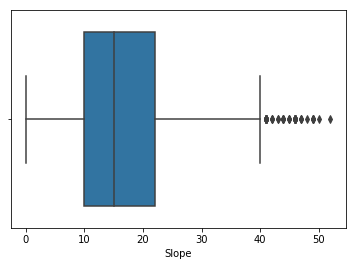

mean        218.97
variance    519.93
Name: Hillshade_Noon, dtype: float64


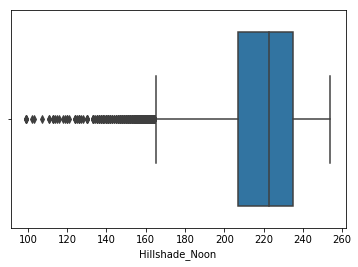

mean        212.70
variance    933.99
Name: Hillshade_9am, dtype: float64


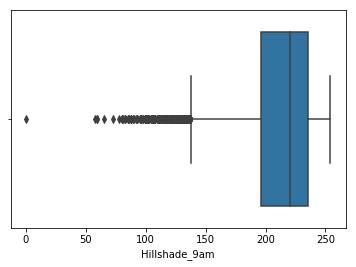

mean         135.09
variance    2106.37
Name: Hillshade_3pm, dtype: float64


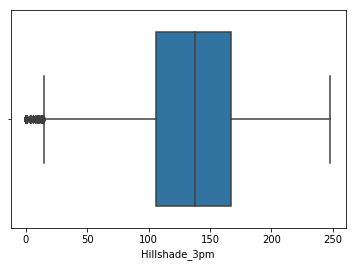

mean          51.08
variance    3750.26
Name: Vertical_Distance_To_Hydrology, dtype: float64


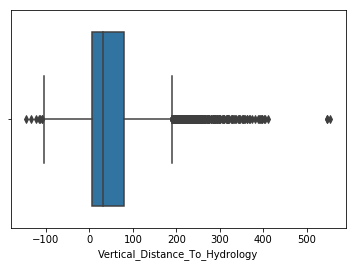

mean          156.68
variance    12118.88
Name: Aspect, dtype: float64


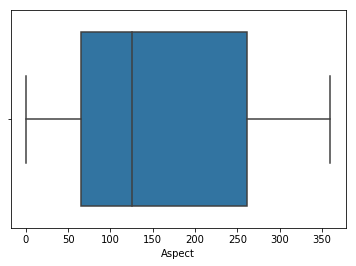

mean          227.20
variance    44131.63
Name: Horizontal_Distance_To_Hydrology, dtype: float64


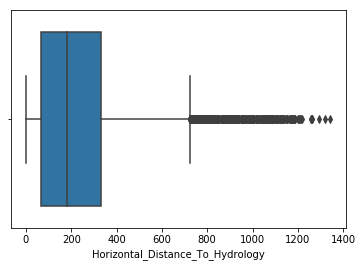

mean          235.95
variance    46436.67
Name: Distance_To_Hydrology, dtype: float64


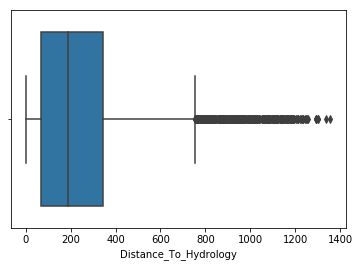

mean          2749.32
variance    174455.07
Name: Elevation, dtype: float64


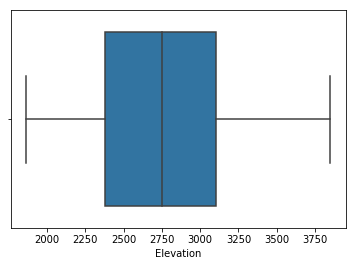

mean           1511.15
variance    1209860.29
Name: Horizontal_Distance_To_Fire_Points, dtype: float64


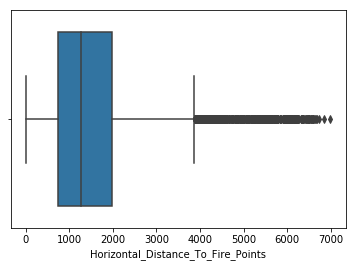

mean           1714.02
variance    1755800.85
Name: Horizontal_Distance_To_Roadways, dtype: float64


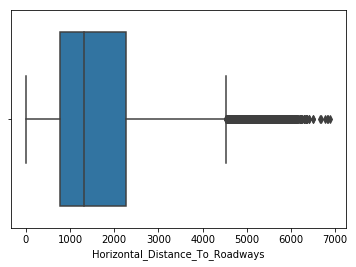

In [27]:
import seaborn as sns
for f_name in numerical_features:
    print(col_stat_df.loc[f_name])
    sns.boxplot(train_df[f_name])
    plt.show()

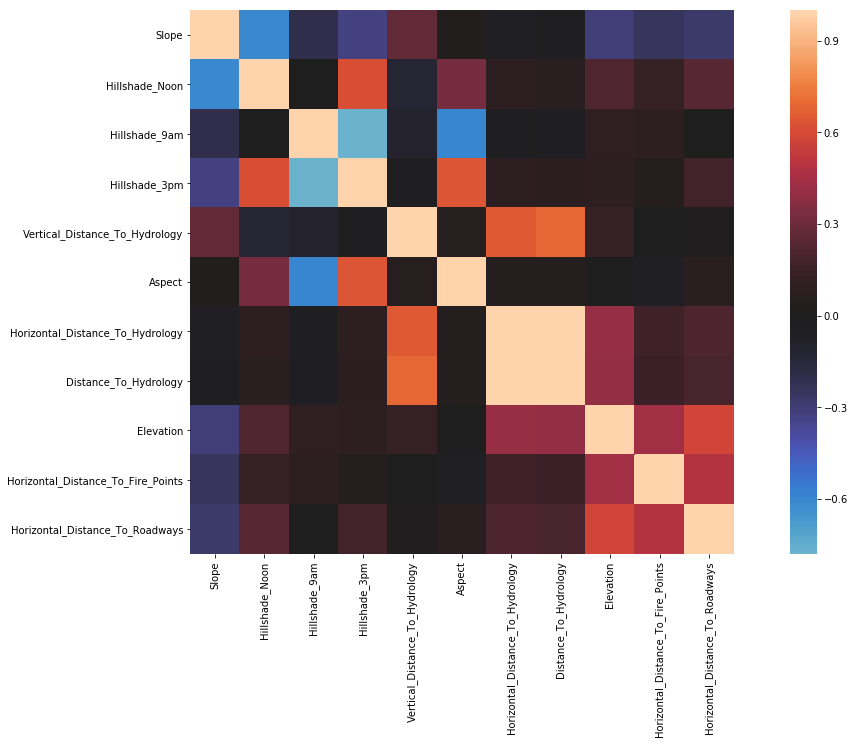

In [28]:
cor_mat = train_df[selected_columns].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(cor_mat, square=True, center=0)

In [31]:
selected_columns = selected_columns.tolist()
selected_columns.remove('Vertical_Distance_To_Hydrology')
selected_columns.remove('Horizontal_Distance_To_Hydrology')

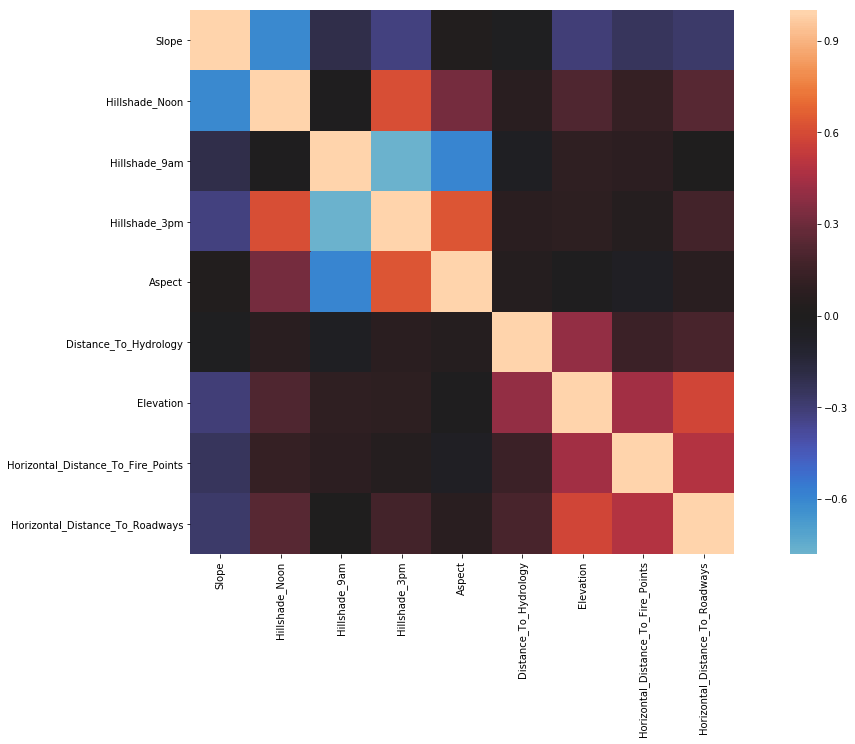

In [32]:
cor_mat = train_df[selected_columns].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(cor_mat, square=True, center=0)

In [13]:
X = train_df[feature_names]  #independent columns
y = train_df[target_var]    

In [ ]:
## Highly correlated 
k = 6
for index in cor_mat.index:
    print('\n',index, ':')
    row = cor_mat.loc[index]
    row = np.abs(row)
    #print(row)
    sorted_row = row.sort_values(ascending=False)
    print(sorted_row[sorted_row.apply(lambda x:x>=0.4)][1:])
    

#### Check multicolinearity

In [25]:
#features = "+".join(df.columns - ["annual_inc"])
from patsy import dmatrices

# get y and X dataframes based on this regression:
y, X = dmatrices(target_var+' ~' + '+'.join(numerical_features), train_df, return_type='dataframe')
X.head()

,Intercept,Slope,Hillshade_Noon,Hillshade_9am,Hillshade_3pm,Vertical_Distance_To_Hydrology,Aspect,Horizontal_Distance_To_Hydrology,Distance_To_Hydrology,Elevation,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways
0,1.0,3.0,232.0,221.0,148.0,0.0,51.0,258.0,258.000000,2596.0,6279.0,510.0
1,1.0,2.0,235.0,220.0,151.0,-6.0,56.0,212.0,212.084889,2590.0,6225.0,390.0
2,1.0,9.0,238.0,234.0,135.0,65.0,139.0,268.0,275.769832,2804.0,6121.0,3180.0
3,1.0,18.0,238.0,238.0,122.0,118.0,155.0,242.0,269.235956,2785.0,6211.0,3090.0
4,1.0,2.0,234.0,220.0,150.0,-1.0,45.0,153.0,153.003268,2595.0,6172.0,391.0


In [26]:
columns = X.columns
X = np.array(X, dtype=float)

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = columns
vif.head()

,VIF Factor,features
0,3633.358663,Intercept
1,8.490819,Slope
2,44.348855,Hillshade_Noon
3,120.026501,Hillshade_9am
4,179.887277,Hillshade_3pm


In [36]:
vif.sort_values('VIF Factor')

,VIF Factor,features
10,1.406229,Horizontal_Distance_To_Fire_Points
11,1.730706,Horizontal_Distance_To_Roadways
6,1.898949,Aspect
9,1.924812,Elevation
1,8.490819,Slope
5,10.364874,Vertical_Distance_To_Hydrology
2,44.348855,Hillshade_Noon
3,120.026501,Hillshade_9am
4,179.887277,Hillshade_3pm
7,1965.000660,Horizontal_Distance_To_Hydrology


### PCA analysis

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_numer = scaler.fit_transform(train_df[numerical_features])

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
svd_res = svd.fit_transform(scaled_X_numer)
#pca = PCA()

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [213]:
svd

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [216]:
for n_components in range(2, len(numerical_features)):
    svd = TruncatedSVD(n_components=n_components, n_iter=100)
    svd_res = svd.fit_transform(scaled_X_numer)
    print(n_components, sum(svd.explained_variance_ratio_))

2 0.5145714496190177
3 0.6972956982989303
4 0.8030408487931546
5 0.8577993694472267
6 0.9057270723657238
7 0.9460433121583127
8 0.9748700303494986
9 0.9997087490648082


In [10]:
svd = TruncatedSVD(n_components=8, n_iter=100)
svd_res = svd.fit_transform(scaled_X_numer)


In [11]:
categorical_features_agg = []
categorical_features_agg.append('Soil_Type')
categorical_features_agg.append('Wilderness_Type')

In [217]:
pca = PCA(n_components=8)
pca_res = pca.fit_transform(scaled_X_numer)
sum(pca.explained_variance_ratio_)

0.9748700303494972

In [12]:
def get_fearures_after_svd(df, numerical_features=numerical_features):
    scaler = StandardScaler()
    scaled_X_num = scaler.fit_transform(df[numerical_features])
    svd = TruncatedSVD(n_components=8, n_iter=100)
    return svd.fit(scaled_X_num).transform(scaled_X_num),scaler,svd
    

In [13]:
def get_processed_categ_features(df):
    soil_res = np.add(np.where(df[soil_features]==1)[1], 1)
    wilder_res = np.add(np.where(df[wilderness_features]==1)[1], 1)
    
    return {'Soil_Type': soil_res, 'Wilderness_Type': wilder_res}

In [14]:
train_X_svd,scaler,svd = get_fearures_after_svd(train_df)

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
sns.heatmap(np.corrcoef(train_X))

KeyboardInterrupt: 

In [21]:
target_var

'Cover_Type'

In [22]:
from scipy.stats import pearsonr
for col_ind in range(train_X_svd.shape[1]):
    print(pearsonr(train_X_svd[:,col_ind], train_df[target_var]))

(0.08568079209111494, 4.860545638924857e-26)
(0.03933287023114222, 1.3116798075718948e-06)
(0.0801678797512454, 5.462178995631281e-23)
(-0.015994801920734648, 0.04921335787959232)
(-0.05547462258093613, 8.728988080857515e-12)
(0.013370926790077677, 0.10016126892400677)
(0.10180988642969065, 3.951226662827913e-36)
(0.030979338518819722, 0.0001390092257810348)


In [25]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

rf_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
res = cross_val_score(rf_model, train_X_svd, train_df[target_var], cv=5, scoring='accuracy')

In [26]:
res.mean()

0.6770502645502645

### Feature importance by tree based model

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00217859 0.00182166 0.00639975 0.00312865 0.00218041 0.00241313
 0.00225478 0.00398432 0.0045138  0.0070017  0.00372988 0.01276066
 0.0061336  0.00688139 0.00482097 0.00684809 0.01919928 0.00367354
 0.00810918 0.00870136 0.02002939 0.0157148  0.00784143 0.01234735
 0.02869961 0.01217982 0.02713667 0.02868004 0.03622996 0.02897813
 0.03863831 0.04123339 0.04406057 0.04193866 0.04331766 0.04864025
 0.04899315 0.04608143 0.17002467 0.06526433 0.07723567]


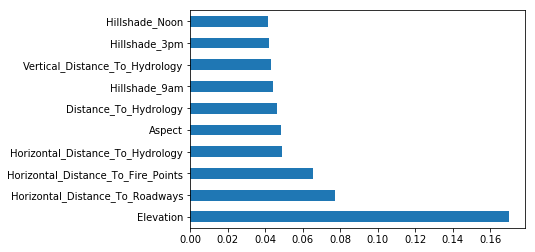

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
X = train_df[feature_names]  #independent columns
y = train_df[target_var]    

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [39]:
feat_importances.sort_values()

Soil_Type16                           0.001822
Soil_Type20                           0.002179
Soil_Type5                            0.002180
Soil_Type1                            0.002255
Soil_Type14                           0.002413
Soil_Type35                           0.003129
Soil_Type6                            0.003674
Soil_Type11                           0.003730
Soil_Type31                           0.003984
Soil_Type24                           0.004514
Soil_Type33                           0.004821
Soil_Type13                           0.006134
Soil_Type12                           0.006400
Soil_Type32                           0.006848
Wilderness_Area2                      0.006881
Soil_Type22                           0.007002
Soil_Type23                           0.007841
Soil_Type2                            0.008109
Soil_Type17                           0.008701
Soil_Type29                           0.012180
Soil_Type30                           0.012347
Soil_Type40  

## Logistic Regression

In [28]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_df[feature_names],
                                                        train_df[target_var], train_size=0.7)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lrModel = LogisticRegression(solver='newton-cg')
lr_model_fit = lrModel.fit(train_x, train_y)
print("Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, lrModel.predict(train_x)))
print("Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, lrModel.predict(test_x)),'\n')

Logistic regression Train Accuracy ::  0.6781934996220711
Logistic regression Test Accuracy ::  0.6697530864197531 



In [33]:
feature_names

['Soil_Type20',
 'Soil_Type16',
 'Soil_Type12',
 'Soil_Type35',
 'Soil_Type5',
 'Soil_Type14',
 'Soil_Type1',
 'Soil_Type31',
 'Soil_Type24',
 'Soil_Type22',
 'Soil_Type11',
 'Soil_Type40',
 'Soil_Type13',
 'Wilderness_Area2',
 'Soil_Type33',
 'Soil_Type32',
 'Soil_Type39',
 'Soil_Type6',
 'Soil_Type2',
 'Soil_Type17',
 'Soil_Type38',
 'Soil_Type4',
 'Soil_Type23',
 'Soil_Type30',
 'Soil_Type3',
 'Soil_Type29',
 'Soil_Type10',
 'Wilderness_Area1',
 'Wilderness_Area4',
 'Wilderness_Area3',
 'Slope',
 'Hillshade_Noon',
 'Hillshade_9am',
 'Hillshade_3pm',
 'Vertical_Distance_To_Hydrology',
 'Aspect',
 'Horizontal_Distance_To_Hydrology',
 'Distance_To_Hydrology',
 'Elevation',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Roadways']

In [36]:
len(feature_names), len(categorical_features), len(numerical_features)

(41, 30, 11)

In [40]:
from sklearn.preprocessing import StandardScaler
for col in categorical_features:
    train_df[col] = train_df[col].astype('int') 
    train_x[col] = train_x[col].astype('int') 
    test_x[col] = test_x[col].astype('int') 
    
scaler = StandardScaler()
scaler.fit(train_df[feature_names])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
scaled_train_x, scaled_test_x = scaler.transform(train_x), scaler.transform(test_x)

In [ ]:
train_x.Elevation, mean(scaled_train_x[:,37]),  variance(scaled_train_x[:,37])

In [31]:
from sklearn.linear_model import LogisticRegression

lrModel_mul = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000)  # lbfgs newton-cg
lrm_model_fit = lrModel_mul.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, lrModel_mul.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, lrModel_mul.predict(test_x)))


Multinomial Logistic regression Train Accuracy ::  0.6006235827664399
Multinomial Logistic regression Test Accuracy ::  0.6025132275132276


In [42]:
from sklearn.linear_model import LogisticRegression

lrModel_mul = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000)  # lbfgs newton-cg
lrm_model_fit = lrModel_mul.fit(scaled_train_x, train_y)

print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, lrModel_mul.predict(scaled_train_x)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, lrModel_mul.predict(scaled_test_x)))


Multinomial Logistic regression Train Accuracy ::  0.7041761148904006
Multinomial Logistic regression Test Accuracy ::  0.7094356261022927


In [ ]:
scaled_X = scaler.transform(train_df[feature_names])

class_labels = np.sort(train_df[target_var].unique())

for class_label in class_labels:
    indices = np.where(train_df[target_var]==class_label)[0]
    sns.distplot(scaled_X[indices][:,37])

### SVM

In [43]:
from sklearn.svm import LinearSVC
linear_svm_model = LinearSVC()
linear_svm_model.fit(scaled_train_x, train_y)

print("Linear SVM Train Accuracy :: ", metrics.accuracy_score(train_y, linear_svm_model.predict(scaled_train_x)))
print("Linear SVM Test Accuracy :: ", metrics.accuracy_score(test_y, linear_svm_model.predict(scaled_test_x)))


Linear SVM Train Accuracy ::  0.6750755857898715
Linear SVM Test Accuracy ::  0.6723985890652557


In [27]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(scaled_train_x, train_y)
print("Linear SVM Train Accuracy :: ", metrics.accuracy_score(train_y, svm_model.predict(scaled_train_x)))
print("Linear SVM Test Accuracy :: ", metrics.accuracy_score(test_y, svm_model.predict(scaled_test_x)))


Linear SVM Train Accuracy ::  0.7238284202569917
Linear SVM Test Accuracy ::  0.7213403880070547


In [28]:
svm_model = SVC(kernel='rbf', gamma='auto')
svm_model.fit(scaled_train_x, train_y)
print("Non-Linear SVM Scaled Train Accuracy :: ", metrics.accuracy_score(train_y, svm_model.predict(scaled_train_x)))
print("Non-Linear SVM Scaled Test Accuracy :: ", metrics.accuracy_score(test_y, svm_model.predict(scaled_test_x)))

# Observation:
# Already Scaled data is much better than non-scaled or using scaling separately

Non-Linear SVM Scaled Train Accuracy ::  0.7517006802721088
Non-Linear SVM Scaled Test Accuracy ::  0.73831569664903


In [ ]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], r, scaled_train_x[:,36], c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

X = scaled_train_x[:,[37,39]]
y = train_y
r = np.exp(-(X ** 2).sum(1))

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(scaled_train_x[:,[37,39]]), y=fixed(train_y));

### Tree Classifiers

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X = scaled_train_x[:,[37,39]]
y = train_y
visualize_classifier(DecisionTreeClassifier(), X, y)


In [47]:
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(n_estimators=100, random_state=0)
rfModel.fit(train_x, train_y)
print("RF Train Accuracy :: ", metrics.accuracy_score(train_y, rfModel.predict(train_x)))
print("RF Test Accuracy :: ", metrics.accuracy_score(test_y, rfModel.predict(test_x)),'\n')
#visualize_classifier(model, train_x, train_y);

RF Train Accuracy ::  1.0
RF Test Accuracy ::  0.857363315696649 



In [48]:
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1, oob_score=True)
rfModel.fit(train_x, train_y)
print("RF Train Accuracy :: ", metrics.accuracy_score(train_y, rfModel.predict(train_x)))
print("RF OOB score :: ", rfModel.oob_score_)
print("RF Test Accuracy :: ", metrics.accuracy_score(test_y, rfModel.predict(test_x)),'\n')
#visualize_classifier(model, train_x, train_y);


RF Train Accuracy ::  1.0
RF OOB score ::  0.8490173847316704
RF Test Accuracy ::  0.857363315696649 



#### Optimization of Hyperparameters

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


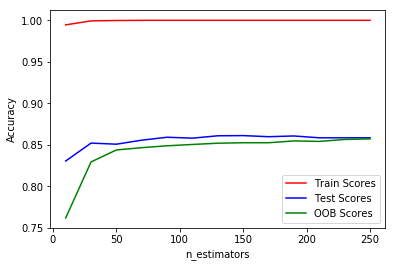

In [60]:
n_estimators_ops = np.arange(10, 270, 20)
train_scores = []
test_scores = []
oob_scores = []

for n_estimator in n_estimators_ops:
    rfModel = RandomForestClassifier(n_estimators=n_estimator, random_state=0, n_jobs=-1, oob_score=True)
    rfModel.fit(train_x, train_y)
    train_scores.append(metrics.accuracy_score(train_y, rfModel.predict(train_x)))
    test_scores.append(metrics.accuracy_score(test_y, rfModel.predict(test_x)))
    oob_scores.append(rfModel.oob_score_)
    
plt.plot(n_estimators_ops, train_scores, 'r', label = 'Train Scores')
plt.plot(n_estimators_ops, test_scores, 'b', label='Test Scores')
plt.plot(n_estimators_ops, oob_scores, 'g', label='OOB Scores')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
list(zip(n_estimators_ops, oob_scores, test_scores))

[(10, 0.7618102796674225, 0.8304673721340388),
 (30, 0.8293650793650794, 0.8520723104056437),
 (50, 0.8438208616780045, 0.8507495590828924),
 (70, 0.8465608465608465, 0.8555996472663139),
 (90, 0.8488284202569917, 0.8591269841269841),
 (110, 0.8504346182917611, 0.8580246913580247),
 (130, 0.8519463340891912, 0.8608906525573192),
 (150, 0.8525132275132276, 0.8611111111111112),
 (170, 0.8525132275132276, 0.8597883597883598),
 (190, 0.8546863189720333, 0.8606701940035273),
 (210, 0.854119425547997, 0.8584656084656085),
 (230, 0.8564814814814815, 0.8584656084656085),
 (250, 0.8571428571428571, 0.8584656084656085)]

In [62]:
best_n_estimator = 130

#### Optimizing on features

In [39]:
# Best RF model as per now -
rfModel = RandomForestClassifier(n_estimators=best_n_estimator, random_state=0, n_jobs=-1, oob_score=True)
rfModel.fit(train_x, train_y)
print("RF Train Accuracy :: ", metrics.accuracy_score(train_y, rfModel.predict(train_x)))
print("RF OOB score :: ", rfModel.oob_score_)
print("RF Test Accuracy :: ", metrics.accuracy_score(test_y, rfModel.predict(test_x)),'\n')


RF Train Accuracy ::  1.0
RF OOB score ::  0.8536470143613001
RF Test Accuracy ::  0.8600088183421517 



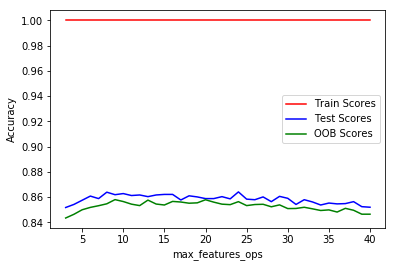

In [91]:
max_features_ops = np.arange(3, len(X.columns)+1)
train_scores = []
test_scores = []
oob_scores = []

for max_features in max_features_ops:
    rfModel = RandomForestClassifier(n_estimators=best_n_estimator,max_features=max_features, random_state=0, n_jobs=-1, oob_score=True)
    rfModel.fit(train_x, train_y)
    train_scores.append(metrics.accuracy_score(train_y, rfModel.predict(train_x)))
    test_scores.append(metrics.accuracy_score(test_y, rfModel.predict(test_x)))
    oob_scores.append(rfModel.oob_score_)
    
plt.plot(max_features_ops, train_scores, 'r', label = 'Train Scores')
plt.plot(max_features_ops, test_scores, 'b', label='Test Scores')
plt.plot(max_features_ops, oob_scores, 'g', label='OOB Scores')
plt.xlabel('max_features_ops')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
features_importances = pd.Series(rfModel.feature_importances_, index=X.columns)
features_importances = features_importances.sort_values(ascending=False)

In [43]:
features_importances[:3].index

Index(['Elevation', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

In [101]:
train_x[features_importances.nlargest(1).index].head()


,Elevation
11481,2738
13517,2360
5419,2299
10424,3598
3149,2913


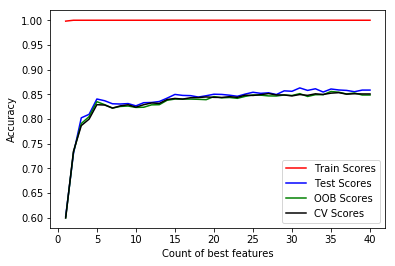

In [45]:
features_cnts = np.arange(1, len(X.columns)+1)
train_scores = []
test_scores = []
oob_scores = []
cv_scores = []

for features_cnt in features_cnts:
    selected_features = features_importances[:features_cnt+1].index
    selected_train_x,selected_test_x  = train_x[selected_features], test_x[selected_features]
    rfModel = RandomForestClassifier(n_estimators=best_n_estimator,random_state=0, n_jobs=-1, oob_score=True)
    rfModel.fit(selected_train_x, train_y)
    train_scores.append(metrics.accuracy_score(train_y, rfModel.predict(selected_train_x)))
    test_scores.append(metrics.accuracy_score(test_y, rfModel.predict(selected_test_x)))
    oob_scores.append(rfModel.oob_score_)
    
    cv_metrics = cross_val_score(rfModel, selected_train_x, train_y, cv=kfold, scoring='accuracy')
    cv_scores.append(cv_metrics.mean())
    
plt.plot(features_cnts, train_scores, 'r', marker='o', label = 'Train Scores')
plt.plot(features_cnts, test_scores, 'b', marker='o', label='Test Scores')
plt.plot(features_cnts, oob_scores, 'g', marker='o', label='OOB Scores')
plt.plot(features_cnts, cv_scores, 'black', marker='o', label='CV Scores')

plt.xlabel('Count of best features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
cv_scores = np.round(cv_scores, 4)
oob_scores = np.round(oob_scores, 4)
test_scores = np.round(test_scores, 4)

In [50]:
features_cnts[np.argmax(cv_scores)],max(cv_scores), features_cnts[np.argmax(oob_scores)],max(oob_scores),features_cnts[np.argmax(test_scores)], max(test_scores)
#list(zip(features_cnts, cv_scores, oob_scores, test_scores))

(36, 0.8533, 35, 0.8556, 31, 0.8629)

In [52]:
print(list(zip(features_cnts, cv_scores, oob_scores, test_scores))[30])
print(list(zip(features_cnts, cv_scores, oob_scores, test_scores))[34])
print(list(zip(features_cnts, cv_scores, oob_scores, test_scores))[35])

(31, 0.8494, 0.8513, 0.8629)
(35, 0.8522, 0.8556, 0.8607)
(36, 0.8533, 0.8541, 0.8587)


## Test scores

In [64]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def make_submission(model, test_X, filename, ids=test_df.Id):
    test_pred_y = model.predict(test_X)
    submission_df = pd.DataFrame({'ID': ids, 'Cover_Type': test_pred_y})
    submission_df.to_csv(filename, index=False)    

In [108]:
for var in category_col_names:
    if var == 'Cover_Type':
        continue
    test_df[var] = test_df[var].astype('category')

In [10]:
best_n_estimator = 130

In [11]:
rfModel1 = RandomForestClassifier(n_estimators=best_n_estimator, random_state=0, n_jobs=-1, oob_score=True)
X = train_df[feature_names]  #independent columns
y = train_df[target_var]    
test_X = test_df[feature_names]

rfModel1.fit(X, y)
print("RF Train Accuracy :: ", metrics.accuracy_score(y, rfModel1.predict(X)))
print("RF OOB score :: ", rfModel1.oob_score_)


#make_submission(rfModel1, test_X,test_df.Id, 'submission1.csv')

NameError: name 'test_df' is not defined

In [116]:
test_pred_y = rfModel1.predict(test_X)
submission_df = pd.DataFrame({'ID': test_df.Id, 'TARGET': test_pred_y})
submission_df.to_csv('submission1.csv', index=False)    

In [17]:
## all feature in
rfModel_basic = RandomForestClassifier(n_estimators=best_n_estimator, random_state=0, n_jobs=-1, oob_score=True)
selected_features = list(train_df.columns)
selected_features.remove('Id')
selected_features.remove(target_var)

X = train_df[selected_features]  #independent columns
y = train_df[target_var]    
test_X = test_df[selected_features]

rfModel_basic.fit(X, y)
print("RF Train Accuracy :: ", metrics.accuracy_score(y, rfModel_basic.predict(X)))
print("RF OOB score :: ", rfModel_basic.oob_score_)

make_submission(rfModel_basic, test_X, 'submission_basic.csv')

RF Train Accuracy ::  1.0
RF OOB score ::  0.8652116402116402


In [24]:
## Extra Trees
from sklearn.ensemble import ExtraTreesClassifier
X = train_df[feature_names]  #independent columns
y = train_df[target_var]    
test_X = test_df[feature_names]

etModel = ExtraTreesClassifier(n_jobs=-1,oob_score=True, bootstrap=True)
etModel.fit(X,y)

print("ET Train Accuracy :: ", metrics.accuracy_score(y, etModel.predict(X)))
print("ET OOB score :: ", rfModel_basic.oob_score_)

make_submission(etModel, test_X, 'submission_et.csv')

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


ET Train Accuracy ::  0.9960978835978836
ET OOB score ::  0.8652116402116402


In [19]:
make_submission(rfModel_basic, test_X, 'submission_basic.csv')

In [22]:
test_pred_y = rfModel_basic.predict(test_X)
submission_df = pd.DataFrame({'ID': test_df.Id, 'TARGET': test_pred_y})
submission_df.to_csv('submission_basic.csv', index=False)    

In [21]:
model

NameError: name 'model' is not defined

## Cross validated RF

In [25]:
from sklearn.model_selection import KFold, cross_val_score

In [30]:
kfold = KFold(11, random_state=1)

In [27]:
def train_model(model, X, y, cv, scoring_metric='accuracy'):
    accuracy = cross_val_score(model, X, y, cv=kfold, scoring=scoring_metric)
    return accuracy.mean()

In [31]:
rfModel = RandomForestClassifier(n_estimators=best_n_estimator, random_state=0, n_jobs=-1, oob_score=True)

print('Random Forest Results:', train_model(rfModel, X, y, kfold))
rfModel.oob_scor

Random Forest Results: 0.8078119503891635


In [34]:
rfModel.oob_score_

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

In [55]:
best_features_cnt = 35
selected_features = features_importances[:best_features_cnt+1].index
selected_train_x,y,selected_test_x  = train_df[selected_features],train_df[target_var], test_df[selected_features]
rfModel = RandomForestClassifier(n_estimators=best_n_estimator,random_state=0, n_jobs=-1, oob_score=True)
rfModel.fit(selected_train_x, y)


make_submission(rfModel, selected_test_x, 'submission_35_Features.csv')

In [56]:
rfModel.oob_score_

0.8674603174603175

## Search best parameters comb

In [ ]:
scaler = Standa
selected_train_x = 

In [62]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
param = {'n_estimators': [100,150,200,300,400, 500, 1000, 2000],
         'min_samples_leaf' : np.arange(1,20)}
         'learning_rate': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]}


rf = RandomForestClassifier()
grider = GridSearchCV(rf, param, n_jobs=-1, cv=5, scoring='accuracy', verbose=True)
res = grider.fit(selected_train_x, y)
res

Fitting 5 folds for each of 152 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed: 37.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 300, 400, 500, 1000, 2000], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [63]:
res.best_score_

0.7881613756613757

In [65]:
res.best_params_, grider.best_params_

({'min_samples_leaf': 1, 'n_estimators': 2000},
 {'min_samples_leaf': 1, 'n_estimators': 2000})

In [66]:
selected_test_x = test_df[selected_features]
make_submission(grider, selected_test_x, 'submission_35_Features+best_params.csv')

In [138]:
rfModel_op = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
scores = cross_val_score(rfModel_op, selected_train_x, y, cv=5, scoring='accuracy')

In [139]:
scores.mean()

0.7867063492063492

In [140]:
scores

array([0.75694444, 0.74702381, 0.77347884, 0.80489418, 0.85119048])

In [141]:
rfModel_op = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
scores = cross_val_score(rfModel_op, selected_train_x, y, cv=5, scoring='accuracy')
scores.mean(), rfModel_op.oob_score_

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

In [142]:
scores.mean()

0.787962962962963

## feature exploration

In [27]:
soil_features = [feature for feature in category_col_names if 'Soil' in feature]
train_df[soil_features].head(2)

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
s = np.sum(train_df[soil_features], axis=1)
s[s!=1]

Series([], dtype: float64)

In [28]:
wilderness_features = [feature for feature in category_col_names if 'Wilderness' in feature]
train_df[wilderness_features].head(2)

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0


In [79]:
s = np.sum(train_df[wilderness_features], axis=1)
s[s!=1]

Series([], dtype: float64)

In [80]:
train_df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [29]:
features_agg = set(feature_names.copy())
features_agg = features_agg.difference(soil_features)
features_agg = features_agg.difference(wilderness_features)
features_agg.add('Soil_Type')
features_agg.add('Wilderness_Type')
features_agg

{'Aspect',
 'Elevation',
 'Hillshade_3pm',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Slope',
 'Soil_Type',
 'Vertical_Distance_To_Hydrology',
 'Wilderness_Type'}

In [30]:
train_df['Soil_Type'] = np.add(np.where(train_df[soil_features]==1)[1], 1)

In [31]:
train_df['Wilderness_Type'] = np.add(np.where(train_df[wilderness_features]==1)[1], 1)

In [121]:
np.where(train_df[soil_features]==1)

(array([    0,     1,     2, ..., 15117, 15118, 15119], dtype=int64),
 array([28, 28, 11, ...,  3,  3,  1], dtype=int64))

In [123]:
np.where(train_df[soil_features].iloc[0]==1)

(array([28], dtype=int64),)

In [125]:
train_df.iloc[0][soil_features[28]], soil_features[28]

(1, 'Soil_Type29')

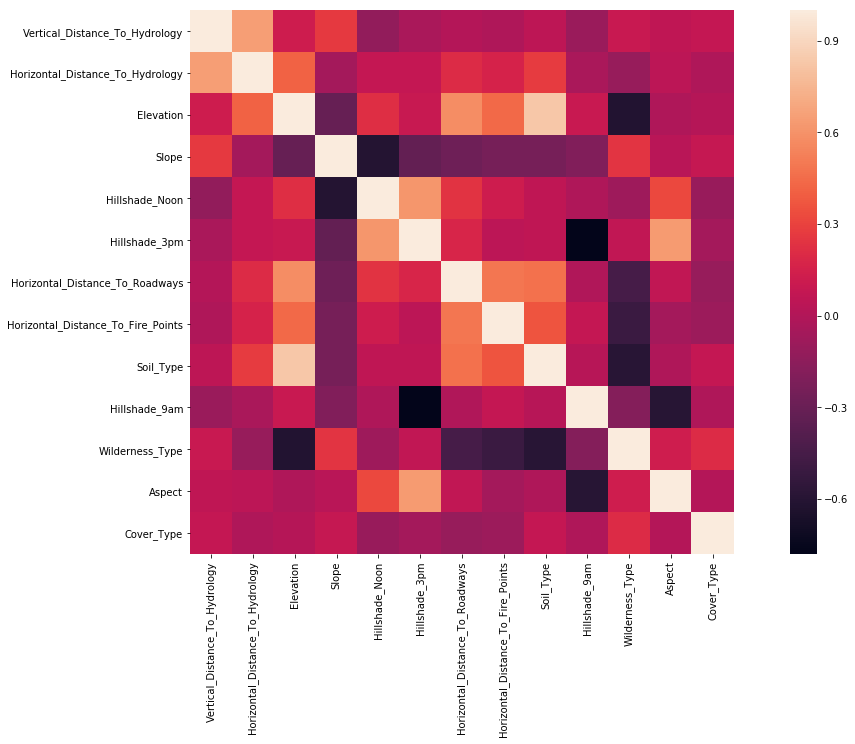

In [137]:
train_df[target_var]=train_df[target_var].astype(int)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(train_df[list(features_agg)+[target_var]].corr(), square=True)

In [143]:
rfModel_op = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
scores = cross_val_score(rfModel_op, train_df[features_agg], y, cv=5, scoring='accuracy')
scores.mean()

0.7895502645502646

In [91]:
hillshade_features = [feature for feature in feature_names if 'Hillshade' in feature]
train_df[hillshade_features].head(2)


,Hillshade_Noon,Hillshade_9am,Hillshade_3pm
0,232,221,148
1,235,220,151


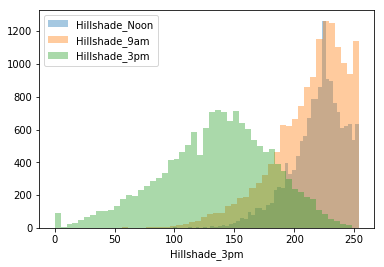

In [98]:
for feature in hillshade_features:
    sns.distplot(train_df[feature], label=feature, kde=False)
    plt.legend()

In [108]:
train_df.groupby(target_var)[hillshade_features[0]]

In [144]:
train_df[hillshade_features+[target_var]].corr()

,Hillshade_Noon,Hillshade_9am,Hillshade_3pm,Cover_Type
Hillshade_Noon,1.000000,-0.013712,0.614526,-0.098905
Hillshade_9am,-0.013712,1.000000,-0.779965,-0.010286
Hillshade_3pm,0.614526,-0.779965,1.000000,-0.053399
Cover_Type,-0.098905,-0.010286,-0.053399,1.000000


Text(0.5, 1.0, 'Hillshade_Noon')

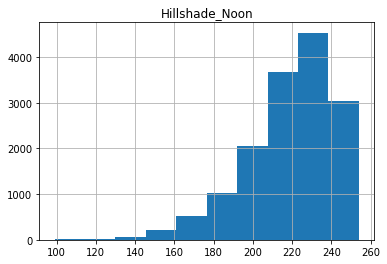

In [152]:
train_df[hillshade_features[0]].hist()
plt.title(hillshade_features[0])

Text(0.5, 1.0, 'Hillshade_9am')

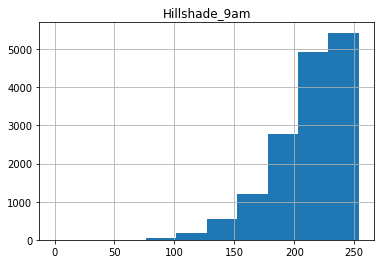

In [151]:
train_df[hillshade_features[1]].hist()
plt.title(hillshade_features[1])

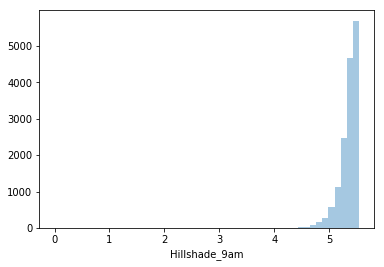

In [163]:
sns.distplot(np.add(train_df[hillshade_features[1]],1).apply(np.log), kde=False)

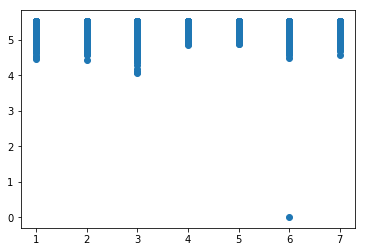

In [165]:
plt.scatter(train_df[target_var] , np.add(train_df[hillshade_features[1]],1).apply(np.log))

Text(0.5, 1.0, 'Hillshade_Noon')

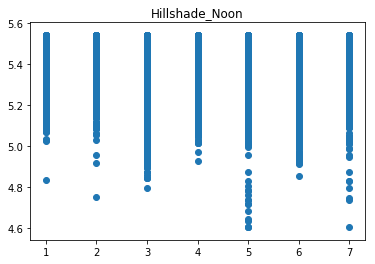

In [169]:
plt.scatter(train_df[target_var] , np.add(train_df[hillshade_features[0]],1).apply(np.log))
plt.title(hillshade_features[0])

In [172]:
from scipy.stats import pearsonr
pearsonr(train_df[hillshade_features[0]], train_df[target_var])

(-0.09890521520398593, 3.4877694984285767e-34)

In [176]:
pearsonr(np.add(train_df[hillshade_features[0]],1).apply(np.log), train_df[target_var])

(-0.09777570534306103, 1.922573975017011e-33)

In [177]:
train_df['Hilshade1_log'] = np.add(train_df[hillshade_features[0]],1).apply(np.log)
train_df['Hilshade2_log'] = np.add(train_df[hillshade_features[1]],1).apply(np.log)
train_df['Hilshade3_log'] = np.add(train_df[hillshade_features[2]],1).apply(np.log)

In [178]:
selected_features = features_agg.copy()
selected_features.remove('Hillshade_9am')
selected_features.remove('Hillshade_Noon')
selected_features.remove('Hillshade_3pm')
selected_features.add('Hilshade1_log')
selected_features.add('Hilshade2_log')
selected_features.add('Hilshade3_log')

In [179]:
rfModel_op = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
scores = cross_val_score(rfModel_op, train_df[selected_features], y, cv=5, scoring='accuracy')
scores.mean()

0.7907407407407407

In [32]:
rfModel_op = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
scores = cross_val_score(rfModel_op, train_df[features_agg], train_df[target_var], cv=5, scoring='accuracy')
scores.mean()

0.7900132275132277

In [34]:
rfModel_op.fit(train_df[features_agg], train_df[target_var])
rfModel_op.oob_score_

0.8716269841269841

In [ ]:
## scaled RF model
scaler = StandardScaler()
scaler.fit(train_df[features_agg], train_df[target_var])
X_train_scaled = scaler.transform(train_df[features_agg])

### XGBoost classifier

In [49]:
xgb_labels = train_df[target_var].apply(lambda x:x-1)

In [75]:
from xgboost import XGBClassifier

alg = XGBClassifier(learning_rate=0.1, n_estimators=2000, subsample=0.6, colsample_bytree=1.0,
                        objective='multi:softmax', eval_metric='mlogloss', num_class=train_df[target_var].nunique(), n_jobs=-1, scale_pos_weight=1, seed=27)

In [76]:
import xgboost as xgb

xgtrain = xgb.DMatrix(train_df[features_agg].values, label=xgb_labels)
xgb_param = alg.get_xgb_params()
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
                          early_stopping_rounds=50)

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [52]:
cvresult.mean()

train-merror-mean    0.109992
train-merror-std     0.002024
test-merror-mean     0.188660
test-merror-std      0.010905
dtype: float64

In [77]:
cvresult.mean()

train-mlogloss-mean    0.297104
train-mlogloss-std     0.003810
test-mlogloss-mean     0.474201
test-mlogloss-std      0.023302
dtype: float64

In [78]:
cvresult.shape

(1102, 4)

In [79]:
alg.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1102, n_jobs=-1,
       nthread=None, num_class=7, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6)

In [80]:
print('Start Training')
alg.fit(train_df[features_agg].values, xgb_labels, eval_metric='mlogloss')

Start Training


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1102, n_jobs=-1,
       nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6)

In [81]:
alg.score(train_df[features_agg].values, xgb_labels)

0.9702380952380952

In [62]:
feat_imp = alg.feature_importances_
feat_imp

array([0.2628116 , 0.04211248, 0.03471815, 0.17014256, 0.03088414,
       0.05694415, 0.0346254 , 0.03500309, 0.07506322, 0.04602896,
       0.04736386, 0.16430241], dtype=float32)

In [82]:
test_df['Soil_Type'] = np.add(np.where(test_df[soil_features]==1)[1], 1)
test_df['Wilderness_Type'] = np.add(np.where(test_df[wilderness_features]==1)[1], 1)
X_test_xgb = test_df[features_agg].values

predictions = alg.predict(X_test_xgb)

In [83]:
predictions = np.add(predictions,1)

In [84]:
submission_df = pd.DataFrame({'ID': test_df['Id'], 'Cover_Type': predictions})
submission_df.to_csv('submissions_xgb_mlogloss.csv', index=False)    

In [183]:
s = test_df[soil_features].sum(axis=1)
s[s!=1]

Series([], dtype: int64)

In [184]:
s = test_df[wilderness_features].sum(axis=1)
s[s!=1]

Series([], dtype: int64)

In [186]:
rfModelOP = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
rfModelOP.fit(train_df[selected_features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [187]:
rfModelOP.oob_score_

0.8718253968253968

In [189]:
features_importances[:best_features_cnt+1].index

Index(['Elevation', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Aspect', 'Hillshade_9am', 'Hillshade_3pm', 'Hillshade_Noon',
       'Wilderness_Area4', 'Slope', 'Soil_Type10', 'Soil_Type3', 'Soil_Type38',
       'Wilderness_Area1', 'Wilderness_Area3', 'Soil_Type39', 'Soil_Type4',
       'Soil_Type40', 'Soil_Type30', 'Soil_Type2', 'Soil_Type17',
       'Soil_Type29', 'Soil_Type22', 'Soil_Type13', 'Soil_Type32',
       'Soil_Type23', 'Soil_Type12', 'Soil_Type33', 'Wilderness_Area2',
       'Soil_Type11', 'Soil_Type6', 'Soil_Type35', 'Soil_Type31',
       'Soil_Type24', 'Soil_Type20'],
      dtype='object')

In [190]:
features_importances[best_features_cnt+1:].index

Index(['Soil_Type1', 'Soil_Type5', 'Soil_Type16', 'Soil_Type14'], dtype='object')

In [191]:
len(selected_features)

12

In [193]:
pd.Series(rfModelOP.feature_importances_, index=selected_features).sort_values(ascending=False)

Elevation                             0.255172
Soil_Type                             0.163400
Horizontal_Distance_To_Roadways       0.097392
Horizontal_Distance_To_Fire_Points    0.079262
Wilderness_Type                       0.063655
Horizontal_Distance_To_Hydrology      0.063315
Hilshade2_log                         0.056550
Vertical_Distance_To_Hydrology        0.052205
Aspect                                0.050438
Hilshade3_log                         0.043301
Hilshade1_log                         0.043226
Slope                                 0.032084
dtype: float64

In [195]:
rfModel = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
rfModel.fit(train_df[features_agg], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [196]:
rfModel.oob_score_

0.8715608465608465

In [198]:
test_df['Soil_Type'] = np.add(np.where(test_df[soil_features]==1)[1], 1)
test_df['Wilderness_Type'] = np.add(np.where(test_df[wilderness_features]==1)[1], 1)
selected_test_x = test_df[features_agg]

make_submission(rfModel, selected_test_x, 'submission_op_feature_eng_nonlog.csv')

In [188]:
test_df['Soil_Type'] = np.add(np.where(test_df[soil_features]==1)[1], 1)
test_df['Wilderness_Type'] = np.add(np.where(test_df[wilderness_features]==1)[1], 1)
test_df['Hilshade1_log'] = np.add(test_df[hillshade_features[0]],1).apply(np.log)
test_df['Hilshade2_log'] = np.add(test_df[hillshade_features[1]],1).apply(np.log)
test_df['Hilshade3_log'] = np.add(test_df[hillshade_features[2]],1).apply(np.log)

selected_test_x = test_df[selected_features]
make_submission(rfModelOP, selected_test_x, 'submission_op+feature_eng.csv')